In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
from pathlib import Path
from sklearn.model_selection import train_test_split
import random
from collections import Counter
from tqdm import tqdm

In [2]:
for root, dirs, files in os.walk('/kaggle/input/hepato/HEPATO/CT'):
    print(f"📂 Folder: {root}")
    print(f"   📁 Subfolders: {dirs}")
    print(f"   📄 Files: {files[:5]}")  # Print only first 5 files per folder
    print("-" * 40)

📂 Folder: /kaggle/input/hepato/HEPATO/CT
   📁 Subfolders: ['HEPATO', 'reem project normal cases']
   📄 Files: []
----------------------------------------
📂 Folder: /kaggle/input/hepato/HEPATO/CT/HEPATO
   📁 Subfolders: []
   📄 Files: ['1436.jpeg', '1528.jpeg', '266.jpeg', '1543.jpeg', '14.jpeg']
----------------------------------------
📂 Folder: /kaggle/input/hepato/HEPATO/CT/reem project normal cases
   📁 Subfolders: []
   📄 Files: ['img (555).jpg', 'img (1105).jpg', 'img (140).jpg', 'img (1796).jpg', 'img (2133).jpg']
----------------------------------------


In [3]:
base_path = Path('/kaggle/input/hepato/HEPATO/CT')
class_map = {
    "HEPATO": 1,
    "reem project normal cases": 0
}

In [4]:
def get_image_paths(base_path, class_map):
    return [(str(path), class_map[subfolder.name])
            for subfolder in base_path.iterdir() if subfolder.is_dir()
            for path in subfolder.glob('*') if path.suffix.lower() in ['.jpeg', '.jpg', '.png']]

def is_image_valid(path):
    try:
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        return img is not None and img.size > 0
    except:
        return False

def load_image(path):
    return cv2.imread(path, cv2.IMREAD_GRAYSCALE)

def visualize_samples(X, y, n=5):
    plt.figure(figsize=(15, 3))
    random_indices = np.random.choice(len(X), size=n, replace=False)
    
    for i, idx in enumerate(random_indices):
        plt.subplot(1, n, i+1)
        plt.imshow(X[idx], cmap='gray')
        plt.title("HEPATO" if y[idx] == 1 else "Normal")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

def check_dimensions(X):
    return Counter([img.shape for img in X])

def plot_intensity_histogram(X):
    all_pixels = np.concatenate([img.flatten() for img in X])
    plt.hist(all_pixels, bins=50, color='gray')
    plt.title('Pixel Intensity Histogram')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()


In [5]:
labeled_paths = get_image_paths(base_path, class_map)

In [6]:
valid_labeled_paths = list(filter(lambda x: is_image_valid(x[0]), tqdm(labeled_paths, desc="Checking for corrupted files")))


Checking for corrupted files: 100%|██████████| 4338/4338 [00:42<00:00, 102.13it/s]


In [7]:
image_paths, labels = zip(*valid_labeled_paths)

In [8]:
X = list(map(load_image, tqdm(image_paths, desc="Loading images")))
y = list(labels)

Loading images: 100%|██████████| 4338/4338 [00:20<00:00, 209.58it/s]


In [9]:
class_counts = Counter(y)
print("Class distribution:", class_counts)

Class distribution: Counter({0: 2181, 1: 2157})


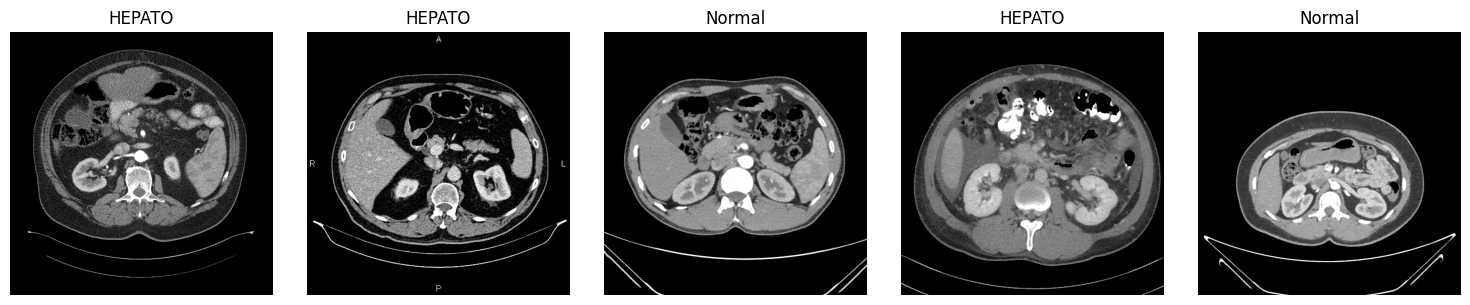

In [10]:
visualize_samples(X, y)

In [11]:
dims = check_dimensions(X)
print("Image dimension consistency:", dims)

Image dimension consistency: Counter({(512, 512): 2181, (630, 630): 1788, (589, 630): 134, (602, 630): 120, (586, 630): 115})


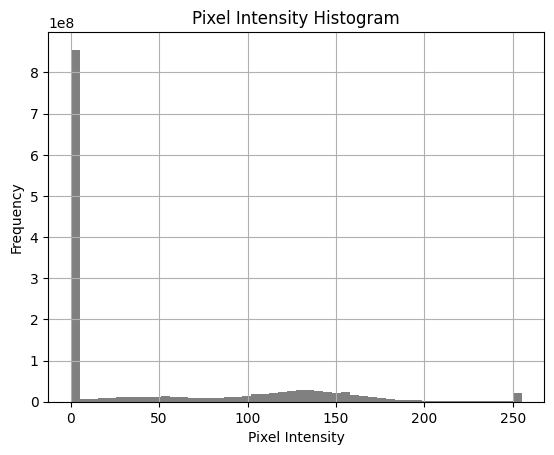

In [12]:
plot_intensity_histogram(X)

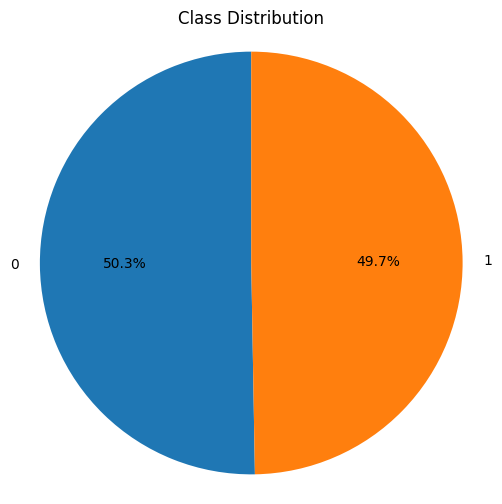

In [13]:
unique_labels, class_counts = np.unique(y, return_counts=True)
plt.figure(figsize=(6, 6))
plt.pie(class_counts, labels=unique_labels, autopct='%1.1f%%', startangle=90)
plt.title("Class Distribution")
plt.axis('equal')  # Equal aspect ratio ensures that pie chart is drawn as a circle.
plt.show()

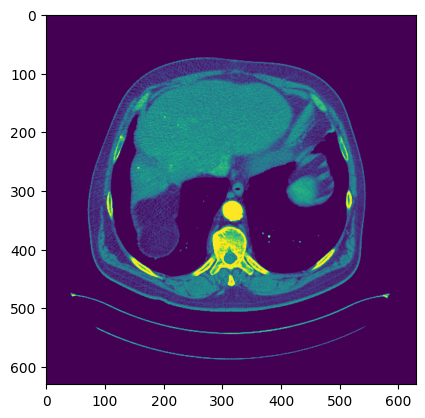

In [14]:
plt.imshow(X[0])

## Preprocessing Pipeline

This section prepares the CT scan images for machine learning. We apply a consistent set of transformations to all images, including:

- Conversion to grayscale numpy arrays (already handled during loading)
- Normalization of pixel values to [0, 1]
- Resizing images to 224x224
- Optional handling of class imbalance (oversampling)

These steps ensure the input data is consistent in format and scale, which improves model training.


## Data Splitting

We split the data into Train, Validation, and Test sets in a 70:15:15 ratio.

Key Considerations:
- Ensured balanced class representation across all splits.
- No patient overlap (if patient IDs are available – here, we assume file-level uniqueness).


## **🧠 Functional Preprocessing Code**


In [15]:
def normalize_image(img, to_range=(0, 1)):
    img = img.astype(np.float32)
    min_val, max_val = np.min(img), np.max(img)
    norm_img = (img - min_val) / (max_val - min_val + 1e-8)
    if to_range == (-1, 1):
        norm_img = norm_img * 2 - 1
    return norm_img

def resize_image(img, size=(224, 224)):
    return cv2.resize(img, size, interpolation=cv2.INTER_AREA)

def preprocess_image(img, size=(224, 224), to_range=(0, 1)):
    return normalize_image(resize_image(img, size), to_range)

def apply_preprocessing(X, size=(224, 224), to_range=(0, 1)):
    return list(map(partial(preprocess_image, size=size, to_range=to_range), tqdm(X, desc="Preprocessing images")))

def split_data(X, y, train_size=0.7, val_size=0.15, test_size=0.15):
    X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=test_size, stratify=y, random_state=42)
    val_ratio = val_size / (train_size + val_size)
    X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=val_ratio, stratify=y_temp, random_state=42)
    return (X_train, y_train), (X_val, y_val), (X_test, y_test)


In [16]:
X_processed = apply_preprocessing(X, size=(224, 224), to_range=(0, 1))

Preprocessing images: 100%|██████████| 4338/4338 [00:04<00:00, 908.00it/s] 


In [17]:
(train_X, train_y), (val_X, val_y), (test_X, test_y) = split_data(X_processed, y)
print(f"Train: {len(train_X)}, Val: {len(val_X)}, Test: {len(test_X)}")

Train: 3036, Val: 651, Test: 651


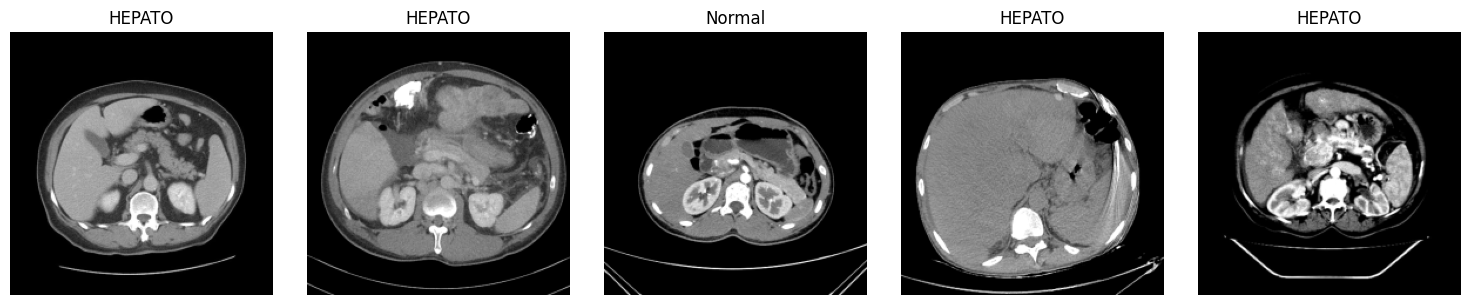

In [18]:
visualize_samples(train_X, train_y)

In [29]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, applications
from sklearn.metrics import f1_score

In [20]:
def to_tf_dataset(X, y, batch_size=32, shuffle=True, augment=False):
    X = np.expand_dims(X, axis=-1)  # grayscale channel
    y = np.array(y)

    dataset = tf.data.Dataset.from_tensor_slices((X, y))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(X))
    dataset = dataset.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.float32)))
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset


def build_baseline_model(input_shape=(224, 224, 1)):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D(),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(256, (3, 3), activation='relu'),
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(.4),
        layers.Dense(1, activation='sigmoid')
    ])
    return model



def compile_model(model, lr=1e-4):
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )

def get_callbacks(name='model'):
    return [
        callbacks.EarlyStopping(monitor='val_auc', patience=5, restore_best_weights=True),
        callbacks.ModelCheckpoint(f'{name}.keras', monitor='val_auc', save_best_only=True)
    ]


In [21]:
def plot_training_history(history, metrics=('loss', 'accuracy', 'auc')):
    """
    Plots training and validation metrics from a Keras History object.

    Parameters:
        history (tf.keras.callbacks.History): The history object returned by model.fit().
        metrics (tuple): List of metric names to plot.
    """
    history_dict = history.history
    epochs = range(1, len(history_dict['loss']) + 1)

    plt.figure(figsize=(5 * len(metrics), 4))

    for i, metric in enumerate(metrics):
        plt.subplot(1, len(metrics), i + 1)
        plt.plot(epochs, history_dict[metric], label=f'Train {metric}')
        val_metric = f'val_{metric}'
        if val_metric in history_dict:
            plt.plot(epochs, history_dict[val_metric], label=f'Val {metric}')
        plt.xlabel('Epochs')
        plt.ylabel(metric.capitalize())
        plt.title(f'{metric.capitalize()} Over Epochs')
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()


In [22]:
# Convert to TF datasets
train_ds = to_tf_dataset(train_X, train_y)
val_ds = to_tf_dataset(val_X, val_y, shuffle=False)
test_ds = to_tf_dataset(test_X, test_y, shuffle=False)

I0000 00:00:1744533836.611340      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [23]:
# Baseline model
baseline_model = build_baseline_model()
compile_model(baseline_model)
history_cnn=baseline_model.fit(train_ds, validation_data=val_ds, epochs=25, callbacks=get_callbacks('baseline'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/25


I0000 00:00:1744533843.054896      95 service.cc:148] XLA service 0x7ff174001ee0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744533843.055347      95 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1744533843.424507      95 cuda_dnn.cc:529] Loaded cuDNN version 90300


 6/95 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.4779 - auc: 0.4918 - loss: 0.6932

I0000 00:00:1744533847.698869      95 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


95/95 ━━━━━━━━━━━━━━━━━━━━ 16s 91ms/step - accuracy: 0.5093 - auc: 0.5691 - loss: 0.6892 - val_accuracy: 0.6636 - val_auc: 0.7431 - val_loss: 0.6426
Epoch 2/25
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.6320 - auc: 0.7070 - loss: 0.6266 - val_accuracy: 0.6406 - val_auc: 0.7776 - val_loss: 0.6540
Epoch 3/25
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.6819 - auc: 0.7401 - loss: 0.5940 - val_accuracy: 0.7189 - val_auc: 0.8248 - val_loss: 0.5354
Epoch 4/25
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.7564 - auc: 0.8180 - loss: 0.5221 - val_accuracy: 0.8187 - val_auc: 0.9002 - val_loss: 0.4472
Epoch 5/25
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.8483 - auc: 0.8905 - loss: 0.4355 - val_accuracy: 0.9078 - val_auc: 0.9364 - val_loss: 0.3687
Epoch 6/25
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.8759 - auc: 0.9196 - loss: 0.3742 - val_accuracy: 0.8356 - val_auc: 0.9545 - val_loss: 0.3827
Epoch 7/25
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - acc

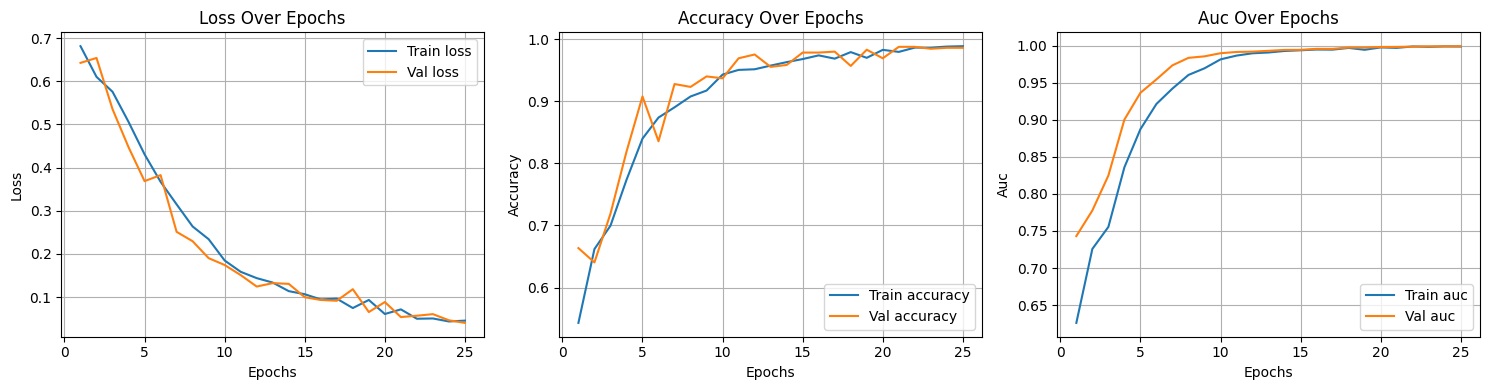

In [24]:
plot_training_history(history_cnn, metrics=('loss', 'accuracy', 'auc'))

In [25]:
# Evaluate the model on the test set
test_loss, test_accuracy, test_auc = baseline_model.evaluate(test_ds)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test AUC: {test_auc}")

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.0199
Test Loss: 0.023265333846211433
Test Accuracy: 1.0
Test AUC: 1.0


In [26]:
baseline_model.save('HEPATO.h5')

In [27]:
model = build_baseline_model()
model.load_weights('HEPATO.h5')  # If you have saved weights

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


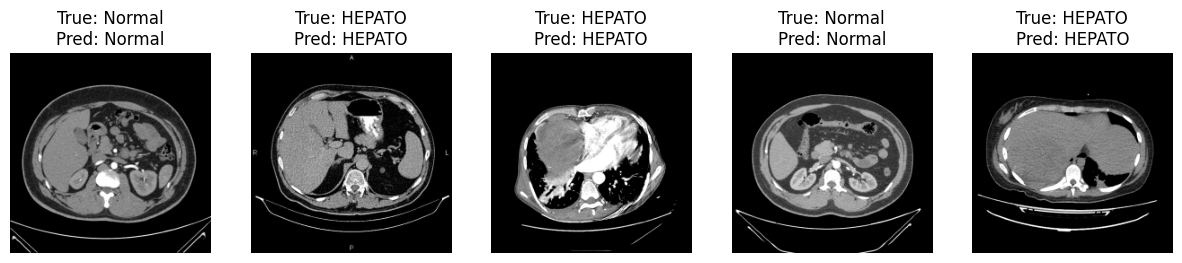

In [28]:
def visualize_predictions(model, test_ds, num_samples=5):
    """
    Visualize some predictions on the test set.
    
    Parameters:
        model (tf.keras.Model): The trained model.
        test_ds (tf.data.Dataset): The test dataset.
        num_samples (int): Number of samples to visualize.
    """
    # Iterate over the test dataset
    iterator = iter(test_ds)
    
    plt.figure(figsize=(15, 10))
    
    for i in range(num_samples):
        images, labels = next(iterator)
        
        predictions = model.predict(images)
        img = images[0].numpy().squeeze()  # Remove channel dimension (if grayscale)
        true_label = labels[0].numpy()
        predicted_label = predictions[0]

        plt.subplot(1, num_samples, i + 1)
        plt.imshow(img, cmap='gray' if img.ndim == 2 else None)  # Use 'gray' colormap if grayscale
        plt.axis('off')
        
        title = f"True: {'HEPATO' if true_label == 1 else 'Normal'}\nPred: {'HEPATO' if predicted_label > 0.5 else 'Normal'}"
        plt.title(title, fontsize=12)

    plt.show()

visualize_predictions(model, test_ds, num_samples=5)